<a href="https://colab.research.google.com/github/tolgagonen/multilabeled-turkish-textclassification-tensorflow/blob/main/multilabeled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [361]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [362]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [363]:
import sys
!pip install -q ftfy
sys.setrecursionlimit(10000)
import ftfy


In [364]:
df = pd.read_csv("7allV03.csv",encoding='UTF-8')
#latin-1 kullandığımda saçma sapan bozulmalar olduğu için yukarıda ki kod parçası ile türkçe karakterleri katıp utf-8 kullandım

In [365]:
df.shape

(4900, 2)

In [366]:
df.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [367]:
print((df.category == "siyaset ").sum()) # Siyaset ile ilgili cümleler
print((df.category == "ekonomi ").sum()) # Ekonomi ile ilgili cümleler
print((df.category == "kultur ").sum()) # kultur ile ilgili cümleler
print((df.category == "dunya ").sum()) # dunya ile ilgili cümleler
print((df.category == "spor ").sum()) # spor ile ilgili cümleler
print((df.category == "saglik ").sum()) # saglik ile ilgili cümleler
print((df.category == "teknoloji ").sum()) # teknoloji ile ilgili cümleler

700
700
700
700
700
700
700


In [368]:
# Tekrar işleme , burada remove_ULR de linkleri yok ediyoruz
#altındaki punct kısmında ise noktaları
import re
import string

def remove_URL(text):
    url =re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", str(text))

def remove_punct(text):
    translator = str.maketrans("","", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [369]:
df["text"] = df.text.map(remove_URL)
df["text"] = df.text.map(remove_punct)

In [370]:
#Twitter gibi uygulamalarda genellikle noktalama işaretlerine çok dikkat edilmez
#Bu yüzden cümlelerin sonunda stopwords dediğimiz cümleleri bitirme kelimeleri bulunur
#Bunlardan burada kurtulmak için hazırlanıyoruz.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#stop words A stop words is a commonly used word (such as "the" , "a")

stop= set(stopwords.words("english"))
stop2= set(stopwords.words("turkish"))

def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop2]
  return " ".join(filtered_words)

def remove_x9X(text):
    special_chars = ['\x92', '\x93', '\x94', '\x95', '\x96']
    cleaned_text = text
    for char in special_chars:
        cleaned_text = cleaned_text.replace(char, '')
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [371]:
df["text"] = df.text.map(remove_stopwords)
df["text"] = df.text.map(remove_x9X)

In [372]:
df.text

0       3 milyon ön seçim vaadi mhp nin 10 olağan büyü...
1       mesutyılmaz yücedivan ceza alabilirdi prof dr ...
2       disko lar kaldırılıyor başbakanyardımcısı arın...
3       sarıgül anayasamahkemesi gidiyor mustafasarıgü...
4       erdoğan idamın bir haklılık sebebi var demek y...
                              ...                        
4895    iphone lara geri dönüyor ios 6 sürümüyle telef...
4896    muslukta devrim sadece elimizi yıkadığımız mus...
4897    halka iyi anlatılmalı bilgiteknolojileri ileti...
4898    çöpe gidiyorlar apple 775 bin uygulamayla apps...
4899    google edwardgorey dedi google ünlü illüstratö...
Name: text, Length: 4900, dtype: object

In [373]:
#Burada tüm farklı kelimeleri sayıyoruz
from collections import Counter

def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

counter = counter_word(df.text)

In [374]:
len(counter)

110888

In [375]:
counter.most_common(5) 

[('bir', 20463),
 ('türkiye', 5475),
 ('nin', 5071),
 ('olarak', 5058),
 ('ın', 4008)]

In [376]:
num_unique_words = len(counter) # Eşsiz Kelime Sayısı

In [377]:
#burada elimdeki category datasındaki 7 farklı kategori için 1-7 değerler veriyorum

df.loc[df['category'] == "siyaset ", 'category'] = 1
df.loc[df['category'] == "ekonomi ", 'category'] = 2
df.loc[df['category'] == "kultur ", 'category'] = 3
df.loc[df['category'] == "dunya ", 'category'] = 4
df.loc[df['category'] == "spor ", 'category'] = 5
df.loc[df['category'] == "saglik ", 'category'] = 6
df.loc[df['category'] == "teknoloji ", 'category'] = 7
df.loc[df['category'] == "teknol ", 'category'] = 7


In [378]:
df.head()

,category,text
0,1,3 milyon ön seçim vaadi mhp nin 10 olağan büyü...
1,1,mesutyılmaz yücedivan ceza alabilirdi prof dr ...
2,1,disko lar kaldırılıyor başbakanyardımcısı arın...
3,1,sarıgül anayasamahkemesi gidiyor mustafasarıgü...
4,1,erdoğan idamın bir haklılık sebebi var demek y...


In [379]:
# Her bir sınıfın verilerini temsil eden liste oluşturma
class_1_data = df.loc[0:500]  
class_2_data = df.loc[700:1200]  
class_3_data = df.loc[1400:1900]  
class_4_data = df.loc[2100:2600] 
class_5_data = df.loc[2800:3300] 
class_6_data = df.loc[3500:4000] 
class_7_data = df.loc[4200:4700]  

# train datasına ekleme
shuffled_df = pd.DataFrame()
shuffled_df = shuffled_df.append(class_1_data)
shuffled_df = shuffled_df.append(class_2_data)
shuffled_df = shuffled_df.append(class_3_data)
shuffled_df = shuffled_df.append(class_4_data)
shuffled_df = shuffled_df.append(class_5_data)
shuffled_df = shuffled_df.append(class_6_data)
shuffled_df = shuffled_df.append(class_7_data)

# Eğitim verilerini karıştırma
shuffled_df = shuffled_df.sample(frac=1).reset_index(drop=True)


<ipython-input-379-14d3da23bfc4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffled_df = shuffled_df.append(class_1_data)
<ipython-input-379-14d3da23bfc4>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffled_df = shuffled_df.append(class_2_data)
<ipython-input-379-14d3da23bfc4>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffled_df = shuffled_df.append(class_3_data)
<ipython-input-379-14d3da23bfc4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffled_df = shuffled_df.append(class_4_data)
<ipython-input-379-14d3da23bfc4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [380]:
# Her bir sınıfın verilerini temsil eden liste oluşturma
val_1_data=df.loc[500:600]
val_2_data=df.loc[1200:1300]
val_3_data=df.loc[1900:2000]
val_4_data=df.loc[2600:2700]
val_5_data=df.loc[3300:3400]
val_6_data=df.loc[4000:4100]
val_7_data=df.loc[4700:4800]

# valid datasına ekleme
valid_df = pd.DataFrame()
valid_df = valid_df.append(val_1_data)
valid_df = valid_df.append(val_2_data)
valid_df = valid_df.append(val_3_data)
valid_df = valid_df.append(val_4_data)
valid_df = valid_df.append(val_5_data)
valid_df = valid_df.append(val_6_data)
valid_df = valid_df.append(val_7_data)

<ipython-input-380-5cc4e186b889>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(val_1_data)
<ipython-input-380-5cc4e186b889>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(val_2_data)
<ipython-input-380-5cc4e186b889>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(val_3_data)
<ipython-input-380-5cc4e186b889>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(val_4_data)
<ipython-input-380-5cc4e186b889>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [381]:
# Her bir sınıfın verilerini temsil eden liste oluşturma
test_1_data=df.loc[600:700]
test_2_data=df.loc[1300:1400]
test_3_data=df.loc[2000:2100]
test_4_data=df.loc[2700:2800]
test_5_data=df.loc[3400:3500]
test_6_data=df.loc[4100:4200]
test_7_data=df.loc[4800:4900]

# valid datasına ekleme
test_df = pd.DataFrame()
test_df = test_df.append(test_1_data)
test_df = test_df.append(test_2_data)
test_df = test_df.append(test_3_data)
test_df = test_df.append(test_4_data)
test_df = test_df.append(test_5_data)
test_df = test_df.append(test_6_data)
test_df = test_df.append(test_7_data)

<ipython-input-381-6f0cb221c1eb>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_1_data)
<ipython-input-381-6f0cb221c1eb>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_2_data)
<ipython-input-381-6f0cb221c1eb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_3_data)
<ipython-input-381-6f0cb221c1eb>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_4_data)
<ipython-input-381-6f0cb221c1eb>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

In [382]:
shuffled_df.head()
#her bir datayı el

,category,text
0,4,olağanüstü hal 3 ay uzatıldı tunus cumhurbaşka...
1,3,bakangünay türk sineması bunu hayal bile etmiy...
2,1,chp li kadın vekillerden arınç a tepki chp li ...
3,5,sbelazığspor ligde kalacak teknik direktör bül...
4,6,amacına ulaştı pilot il olarak konya uygulanma...


In [383]:
train_df = shuffled_df
val_df = valid_df

#Textleri ve type 'ları ayırıyorum
train_sentences = train_df['text'].to_numpy()
train_labels = train_df['category'].to_numpy()
val_sentences = val_df['text'].to_numpy()
val_labels = val_df['category'].to_numpy()
test_sentences = test_df['text'].to_numpy()
test_labels = test_df['category'].to_numpy()

In [384]:
test_df.head()

,category,text
600,1,üstad a saldırının nedeni fikirlerinden korkm...
601,1,hüseyinçelik ten kenanevren yorumu akparti gen...
602,1,eski milletvekili oğuz aygün vefat etti ankara...
603,1,askeri yemini meclis e taşıdı chp mersin mille...
604,1,günay dan başbakan ın açıklamasına ilk yorum a...


In [385]:
train_sentences.shape , val_sentences.shape , train_labels.shape , test_labels.shape

((3507,), (707,), (3507,), (706,))

In [386]:
train_labels

array([4, 3, 1, ..., 3, 5, 1], dtype=object)

In [387]:
#tokenizer paragrafları ve cümleleri daha kolay anlam atanabilecek daha küçük birimlere ayırır

from tensorflow.keras.preprocessing.text import Tokenizer

#vectorize a text corpus by turning each text into a sequance of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

In [388]:
#Her kelimenin kendine özel bir indexi var
word_index = tokenizer.word_index

In [389]:
word_index

{'bir': 1,
 'türkiye': 2,
 'nin': 3,
 'olarak': 4,
 'ın': 5,
 'olan': 6,
 'olduğunu': 7,
 'in': 8,
 'dedi': 9,
 'nın': 10,
 '2': 11,
 '1': 12,
 '3': 13,
 'kadar': 14,
 'ilk': 15,
 'yüzde': 16,
 'büyük': 17,
 'yeni': 18,
 'a': 19,
 'sonra': 20,
 'söyledi': 21,
 'bin': 22,
 '5': 23,
 'son': 24,
 'önemli': 25,
 'var': 26,
 'ilgili': 27,
 'yıl': 28,
 'milyon': 29,
 'göre': 30,
 'etti': 31,
 'ifade': 32,
 '4': 33,
 'yer': 34,
 'olduğu': 35,
 'e': 36,
 'tarafından': 37,
 'iyi': 38,
 'devam': 39,
 'eden': 40,
 '10': 41,
 'iki': 42,
 'ancak': 43,
 'ye': 44,
 'yapılan': 45,
 'önce': 46,
 'konuştu': 47,
 'istanbul': 48,
 'arasında': 49,
 'türk': 50,
 'oldu': 51,
 'dr': 52,
 'un': 53,
 '6': 54,
 'dan': 55,
 'değil': 56,
 'yaptığı': 57,
 'fazla': 58,
 'ardından': 59,
 'den': 60,
 'içinde': 61,
 'sadece': 62,
 'aynı': 63,
 'nde': 64,
 'zaman': 65,
 'abd': 66,
 '2012': 67,
 'nun': 68,
 'şekilde': 69,
 'özel': 70,
 'şöyle': 71,
 'geçen': 72,
 'ortaya': 73,
 'bunun': 74,
 'milyar': 75,
 '7': 76,
 'bir

In [390]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [391]:
print(train_sentences[10:15])
print(train_sequences[10:15])

['nedenyoksulluk twitter yanıt arıyor nedenyoksulluk sorusunun cevabı 25 kasım dan itibaren 2 ay boyunca cumartesi günleri cnntürk ekranlarında bir dizi belgesel yanıt bulacak twitter takipçilerimiz nedenyoksulluk etiketi sorunun yanıtını tartışıyorlar'
 'ekonomiyi uçuracak proje ulaştırma denizcilik haberleşmebakanıbinaliyıldırım yapımı devam eden hızlı tren hatlarının devreye girmesiyle yılda 30 milyon yolcu taşıyacak yüksekhızlıtren nin yht türkiye ekonomisine yıllık 800 milyon doları aşan katkı sağlayacağını bildirdi bakanyıldırım aa muhabirine yaptığı açıklamada türkiye nin yht teknolojisine sahip dünyada 8 inci avrupa 6 ıncı ülke olduğunu hatırlattı türkiyecumhuriyeti devletdemiryolları nın tcdd 2023 yılı hedefleri doğrultusunda yurt genelinde demiryolu ağının 25 bin kilometreye çıkarılacağını ifade eden yıldırım ağın 10 bin kilometresini oluşturacak yht hatlarının ekonomik sosyal kültürel kalkınmaya önemli katkı sağlayacağını vurguladı yapımı devam eden dört büyük kenti birbirin

In [392]:
# dizileri aynı uzunluğa sahip olacak şekilde doldurun
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length=20
 
train_padded= pad_sequences(train_sequences , maxlen=max_length , padding="post",truncating="post")
val_padded= pad_sequences(val_sequences, maxlen=max_length, padding="post" , truncating="post")
test_padded= pad_sequences(test_sequences, maxlen=max_length, padding="post" , truncating="post")
train_padded.shape , val_padded.shape

((3507, 20), (707, 20))

In [393]:
train_padded[10]

array([14958,   527,   864,  3628, 14958, 12134,  4440,   211,   121,
          55,   413,    11,   168,   356,  2467,  2080,  3515, 14959,
           1,  2326], dtype=int32)

In [394]:
val_padded[10]

array([  209, 68018,  1153,   209,   300,   676,     3,    38,  3758,
         311, 47304,  4854,   679,  1211,     1,   452,   107,     1,
        3510,     6], dtype=int32)

In [395]:
test_padded[10]

array([ 2268, 26390,  2785,   419,  2123,  1431, 10405,   720,  5413,
          95,   509,   298,     6,   848,   295, 44179, 24190, 14610,
         419,   273], dtype=int32)

In [396]:
train_labels[1481]

2

In [397]:
val_labels[500]

6

In [398]:
test_labels[500]

6

In [399]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

nedenyoksulluk twitter yanıt arıyor nedenyoksulluk sorusunun cevabı 25 kasım dan itibaren 2 ay boyunca cumartesi günleri cnntürk ekranlarında bir dizi belgesel yanıt bulacak twitter takipçilerimiz nedenyoksulluk etiketi sorunun yanıtını tartışıyorlar
[14958, 527, 864, 3628, 14958, 12134, 4440, 211, 121, 55, 413, 11, 168, 356, 2467, 2080, 3515, 14959, 1, 2326, 1643, 864, 6497, 527, 52724, 14958, 6871, 1243, 2626, 52725]
[14958   527   864  3628 14958 12134  4440   211   121    55   413    11
   168   356  2467  2080  3515 14959     1  2326]


In [342]:
# Burada indexleri tersine çevirerek kontrol ediyoruz
reverse_word_index= dict([(idx , word) for  (word,idx) in word_index.items()])

In [343]:
def decode(sequence):
  return " ".join([reverse_word_index.get(idx , "?") for idx in sequence])

In [400]:
decoded_text = decode(train_sequences[10])
print(train_sequences[10])
print(decoded_text)

[14958, 527, 864, 3628, 14958, 12134, 4440, 211, 121, 55, 413, 11, 168, 356, 2467, 2080, 3515, 14959, 1, 2326, 1643, 864, 6497, 527, 52724, 14958, 6871, 1243, 2626, 52725]
mütevazi twitter yanıt gazı mütevazi kaldırılmasının devlethastanesi 50 kasım dan oluşan 2 ay boyunca açıklayan bıraktı gördüm özelleştirilmesinin bir olmadığına siyah yanıt tabir twitter organizasyonumuzda mütevazi ulaşıyor çalışıyor filmlerin yürüteceğinden


In [401]:
#LSTM modeli yapıyoruz.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Model oluşturma
model = Sequential()
model.add(Embedding(input_dim=num_unique_words, output_dim=100, input_length=20))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=7, activation='softmax'))



model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 100)           11088800  
                                                                 
 lstm_18 (LSTM)              (None, 20, 128)           117248    
                                                                 
 lstm_19 (LSTM)              (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 7)                 903       
                                                                 
Total params: 11,338,535
Trainable params: 11,338,535
Non-trainable params: 0
_________________________________________________________________


In [402]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [403]:
len(train_padded) , len(val_padded) , len(test_padded)

(3507, 707, 706)

In [406]:
from sklearn.preprocessing import OneHotEncoder

# Tüm kategorileri birleştirerek unique kategorileri belirleyin
all_labels = np.concatenate((train_labels, val_labels), axis=0)
unique_labels = np.unique(all_labels)

# One-hot encoder oluşturun ve unique kategorileri ileti
encoder = OneHotEncoder(categories=[unique_labels])
train_labels_encoded = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
val_labels_encoded = encoder.transform(val_labels.reshape(-1, 1)).toarray()
test_labels_encoded = encoder.transform(test_labels.reshape(-1,1)).toarray()


In [405]:
history = model.fit(train_padded, train_labels_encoded, validation_data=(val_padded, val_labels_encoded), epochs=5)
#burada modeli kaydediyorum
model.save('path/save/model1') 


Epoch 1/5
110/110 [==============================] - 55s 404ms/step - loss: 1.4661 - accuracy: 0.4217 - val_loss: 0.9083 - val_accuracy: 0.6846
Epoch 2/5
110/110 [==============================] - 45s 407ms/step - loss: 0.3826 - accuracy: 0.8660 - val_loss: 0.6352 - val_accuracy: 0.8161
Epoch 3/5
110/110 [==============================] - 44s 400ms/step - loss: 0.0792 - accuracy: 0.9763 - val_loss: 0.7034 - val_accuracy: 0.7977
Epoch 4/5
110/110 [==============================] - 44s 399ms/step - loss: 0.0220 - accuracy: 0.9954 - val_loss: 0.7261 - val_accuracy: 0.8062
Epoch 5/5
110/110 [==============================] - 46s 420ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.8344 - val_accuracy: 0.8062


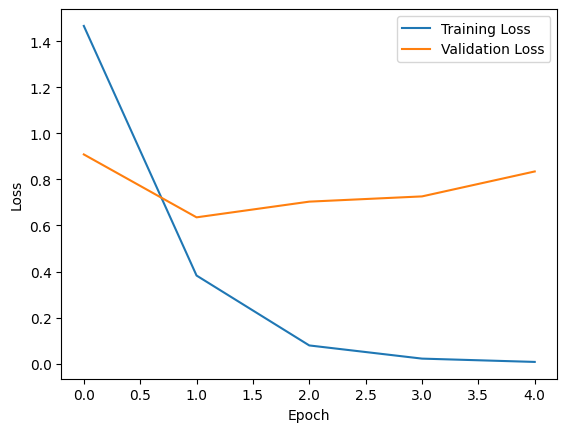

In [407]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybı grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [408]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


In [412]:
model = tf.keras.models.load_model('path/save/model1')
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_encoded)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


23/23 [==============================] - 1s 16ms/step - loss: 0.9220 - accuracy: 0.7776
Test Loss: 0.9220207333564758
Test Accuracy: 0.7776203751564026


In [417]:
model = tf.keras.models.load_model('path/save/model1')
predictions = model.predict(test_padded)

label_mapping = {0: "Siyaset", 1: "Ekonomi", 2: "Kültür", 3: "Dünya", 4: "Spor" , 5: "Saglik" , 6: "Teknoloji"}

for i in range(len(test_sentences)):
    print('Cümle:', test_sentences[i])
    predicted_label = label_mapping[np.argmax(predictions[i])]
    true_label = label_mapping[np.argmax(test_labels_encoded[i])]
    print('Tahmin Edilen Etiket:', predicted_label)
    print('Gerçek Etiket:', true_label)
    print('-----------------------')


23/23 [==============================] - 1s 17ms/step
Cümle: üstad  a saldırının nedeni fikirlerinden korkmaları büyük şair fikir adamı necipfazıl kısakürek  in kurucusu olduğu büyük doğu yayınevi  nin editörlerinden suat ak son günlerde üstad hakkında yapılan karalamalara sert tepki gösterdi suat ak kısakürek hakkında yapılan yayınlardan örnekler vererek örtülü ödenek iddiasının 60 yıldır konuşulduğunu hatırlatarak üstad  ın yassıada hakimlerine verdiği  ben örtülü ödenekten methiyeci kasideci eski roma cenazelerinde ölü arabaları arkasındaki ağlayıcılar vicdan kiracısı olarak para almadım 1943  ten 1960  a kadar taştan taşa vurulan zindandan zindana süründürülen mukaddesatçı milliyetçi anadolucu ahlakçı bir idealin himayesi yolunda para aldım bir fikir karşılığıdır  cevabını aktardı fikir dalgasını durduramazsınız suat ak kumarhane iddiasının komplo olduğunu ifade etti suat ak şöyle konuştu  necipfazıl şahsı davasıyla türkiye  kimsenin cesaret edemeyeceği kadar açık ortada bir şahsiy

23/23 [==============================] - 2s 76ms/step


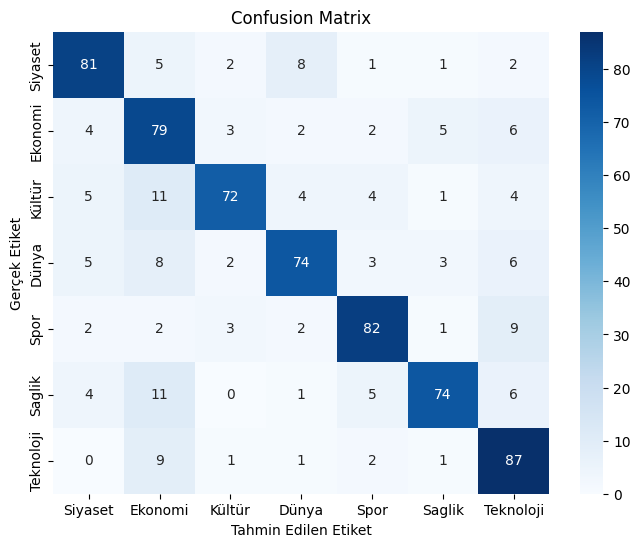

In [419]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tahminler
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_encoded, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Etiket isimleri
label_names = [label_mapping[i] for i in range(len(label_mapping))]

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Confusion Matrix')
plt.show()

In [427]:
sentence = "thy özelleştiriliyor maliyebakanımehmetşimşek thy nin özelleştirilmesi anda gündemde değil thy zaten özel bir şirket thy nin yüzde 51 den fazlası halka açık dedi şimşek türkhavayolları nın 200 uçağının tanıtımı atatürkhavalimanı teknik aş yeni hangar düzenlenen etkinlikte gazetecilerin sorularını yanıtladı şimşek bir gazetecinin merkel in thy ortaklık konusunda bir açıklaması oldu konuyla ilgili söyleyebilirsiniz sorusuna thy lufthansa arasında işbirliğine ilişkin bir çalışma var işbirliğinin artırılması özellikle alanlarda diyaloğun ticari anlamda geliştirilmesi anlamında bir çalışma var henüz bunun erken thy üst yönetimkurulu başkanı karşı tarafla çalışıyorlar aşamada bizim söyleyebileceğimiz kadar karşılığını verdi thy nin özelleştirmesi konusunda bir netlik var sorusu üzerine bakanşimşek thy nin özelleştirilmesi anda gündemde değil thy zaten özel bir şirket thy nin yüzde 51 den fazlası halka açık kamunun tabii yönetim anlamında bir kontrolü var özel bir şirket thy tabii bayrak taşıyıcısı thy nin aşamada ilave bir halka arzı satışı gündemimizde değil konuştu mehmetşimşek özelleştirme kapsamında bir ihale yapıldı akdenizelektrik dağıtım ihalesinin oluşan fiyatı değerlendiriyorsunuz sorusunu şöyle cevapladı özelleştirmemiz son derece şeffaf bir şekilde geniş katılımla televizyon ekranlarının önünde yapılıyor sizler zaten izlediniz fiyatı belirlemeyiz piyasa belirler piyasanın değişen dinamikleri var bunlar nihai bir satış değil bunlar işletme hakkının geçici olarak kamudan özel sektöre devrini içeriyor süreler azaldıkça fiyata yansıyor ayrıca uluslararası finansman koşulları etkili oluyor bunun ötesinde önceki fiyatlarla fiyatı karşılaştırmak anlamlı olmayabilir herkes teminatını yakıp alımdan vazgeçmiştir piyasa fiyatlarını arz talep belirliyor komisyonun belirlediği minimum değer var değerin altında olması halinde satışlar söz konusu değil özelleştirme yüksek kurulu karar verecek şeffaf son derece açık piyasa koşullarında olaya çerçevede yaklaşmak lazım bakanşimşek halkbank ın yarın 2 halka arzı söz konusu orada kadarlık bir gelir bekleniyor sorusuna karşılık şunları ifade etti fiyat aralığı belirlendi anki piyasa değeri belli çerçevede an gidiyor dolayısıyla gelecek talebe bağlı türkiye nin geleceği son derece parlak bankacılık sektörü ilginin yoğun olduğu cazip bir sektör inanıyoruz halkbank iyi bir başlangıç sağlanır dediğim tekrar değerler fiyatlar konusunda yorum yapmak istemiyorum oradan gelecek kaynağın tamamını hazine ye aktarıyoruz özelleştirmeden gelen kaynakların tamamını hazine ye aktarıyoruz hazine bunu kamu borcunu finansmanında kullanıyor borç ödemelerinde kullanıyor özelleştirme kapsamındaki şirketlerin giderleri oluyor"

input_sequence = tokenizer.texts_to_sequences([sentence])
input_padded = pad_sequences(input_sequence, maxlen=20, truncating='post')

model = tf.keras.models.load_model('path/save/model1')
prediction = model.predict(input_padded)
predicted_label = np.argmax(prediction)

predicted_label_name = label_mapping[predicted_label]

print("Cümle:", sentence)
print("Tahmin Edilen Etiket:", predicted_label_name)


1/1 [==============================] - 1s 515ms/step
Cümle: thy özelleştiriliyor maliyebakanımehmetşimşek thy nin özelleştirilmesi anda gündemde değil thy zaten özel bir şirket thy nin yüzde 51 den fazlası halka açık dedi şimşek türkhavayolları nın 200 uçağının tanıtımı atatürkhavalimanı teknik aş yeni hangar düzenlenen etkinlikte gazetecilerin sorularını yanıtladı şimşek bir gazetecinin merkel in thy ortaklık konusunda bir açıklaması oldu konuyla ilgili söyleyebilirsiniz sorusuna thy lufthansa arasında işbirliğine ilişkin bir çalışma var işbirliğinin artırılması özellikle alanlarda diyaloğun ticari anlamda geliştirilmesi anlamında bir çalışma var henüz bunun erken thy üst yönetimkurulu başkanı karşı tarafla çalışıyorlar aşamada bizim söyleyebileceğimiz kadar karşılığını verdi thy nin özelleştirmesi konusunda bir netlik var sorusu üzerine bakanşimşek thy nin özelleştirilmesi anda gündemde değil thy zaten özel bir şirket thy nin yüzde 51 den fazlası halka açık kamunun tabii yönetim anla